<a href="https://colab.research.google.com/github/Fondzenyuy/Google-Collab/blob/main/Preposter_ML_Model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hyperparameters : Optuna (see Notebook)

# Loading Data&Inputs

In [6]:
# Hyperparameters

learning_rate = 0.001
batch_size = 64
num_epochs = 1200

In [7]:
import sys, os, time
import matplotlib.pyplot as plt
import numpy as np
#import optuna
#from optuna.trial import TrialState
import torch
import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import DataLoader  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!
from torch.utils.data import Dataset, DataLoader
torch.manual_seed(0)

In [8]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Aug  1 14:14:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    29W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

__CUDNN VERSION: 8302
__Number CUDA Devices: 1
__CUDA Device Name: Tesla P100-PCIE-16GB
__CUDA Device Total Memory [GB]: 17.071734784


In [10]:
class Data(Dataset):
    
    # Constructor
    def __init__(self, N_SAMPLES = 7000, noise_std=1, train=True):
        self.len = N_SAMPLES
        self.x = torch.linspace(-1, 1, N_SAMPLES).view(-1, 1)
        #self.x = (self.x).to(device)
        self.f = (self.x)*torch.sin(20*self.x) - ((self.x)**2)*torch.cos(10*self.x)  #key function in model for outputs
        #self.f = (self.f).to(device)
        if train != True:
            torch.manual_seed(1)
            self.y = self.f + noise_std * torch.randn(self.f.size())
            self.y = self.y.view(-1, 1)
            #self.y = (self.y).to(device)
            torch.manual_seed(0)
        else:
            self.y = self.f + noise_std * torch.randn(self.f.size())
            self.y = self.y.view(-1, 1)
            #self.y = (self.y).to(device)
            
    # Getter
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len

In [11]:
data_set = Data()

# CNN

In [12]:
# Simple CNN
class Net(nn.Module):
    # Constructor
    def __init__(self, in_size, n_hidden, out_size, p=0):
      super(Net, self).__init__()
      self.drop = nn.Dropout(p=p)
      self.linear1 = nn.Linear(in_size, n_hidden)
      self.linear2 = nn.Linear(n_hidden, n_hidden)
      self.linear3 = nn.Linear(n_hidden, out_size)
        
    def forward(self, x):

      # x = F.relu(self.drop(self.linear1(x))).to(device)
      
      x = self.linear1(x)
      x = self.drop(x)
      x = F.relu(x)

      x = F.relu(self.drop(self.linear2(x)))
      x = self.linear3(x)
      return x

In [13]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Pre-training: Loaders & Model Setup

In [14]:

train_loader = DataLoader(data_set, shuffle= True, batch_size = batch_size)
validation_set = Data(train=False)
val_xtrain = (validation_set.x).to(device=device)
val_ytrain = (validation_set.y).to(device=device)



In [15]:
# Initialize network
model = Net(1,350,1).to(device)
model_drop = Net(1, 350, 1, p=0.5).to(device)
model.train()
model_drop.train()

Net(
  (drop): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=1, out_features=350, bias=True)
  (linear2): Linear(in_features=350, out_features=350, bias=True)
  (linear3): Linear(in_features=350, out_features=1, bias=True)
)

In [16]:
# Loss and optimizer
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
# Set the optimizer and criterion function

optimizer_ofit = torch.optim.Adam(model.parameters(), learning_rate)
optimizer_drop = torch.optim.Adam(model_drop.parameters(), learning_rate)
criterion = torch.nn.MSELoss()

In [18]:
# Initialize the dict to contain the loss results for model

LOSS={}
LOSS['training data no dropout']=[]
LOSS['validation data no dropout']=[]
LOSS['training data dropout']=[]
LOSS['validation data dropout']=[]

# Training

In [19]:

train_loader = DataLoader(data_set, shuffle= True, batch_size = 64)
data = (data_set.x).to(device=device)
val_xtrain = (validation_set.x).to(device=device)
val_ytrain = (validation_set.y).to(device=device)
target = (data_set.y).to(device=device)

# Train Network

def train_model(num_epochs):
  for epoch in range(num_epochs):
    for i , (x, y) in enumerate(train_loader):
      # Get data to cuda if possible
      model.train()
      data = (data_set.x).to(device=device)
      val_xtrain = (validation_set.x).to(device=device)
      val_ytrain = (validation_set.y).to(device=device)
      yhat = model(data)
      yhat_drop = model_drop(data)

      target = (data_set.y).to(device=device)
      loss = criterion(yhat,target)
      loss_drop = criterion(yhat_drop, target)

      #store the loss for  both the training and validation  data for both models 
      LOSS['training data no dropout'].append(loss.item())
      LOSS['validation data no dropout'].append(criterion(model(val_xtrain), val_ytrain).item())
      LOSS['training data dropout'].append(loss_drop.item())
      model_drop.eval()
      LOSS['validation data dropout'].append(criterion(model_drop(val_xtrain), val_ytrain).item())
      model_drop.train()
      
      #backward 
      optimizer_ofit.zero_grad()
      optimizer_drop.zero_grad()
      loss.backward()
      loss_drop.backward()
      optimizer_ofit.step()
      optimizer_drop.step()

train_model(num_epochs)
    
    

    
    


In [20]:
#Set the model with dropout to evaluation mode

model_drop.eval()

Net(
  (drop): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=1, out_features=350, bias=True)
  (linear2): Linear(in_features=350, out_features=350, bias=True)
  (linear3): Linear(in_features=350, out_features=1, bias=True)
)

In [21]:
# Make the prediction

yhat = model(data)
yhat_drop = model_drop(data)

# Analysis

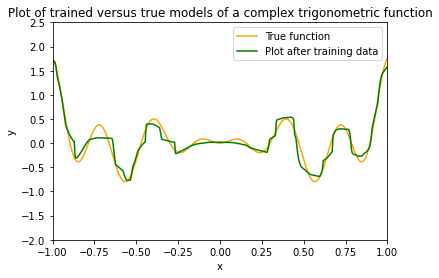

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [26]:
#Plot the predictions for both models
#plt.figure(figsize=(6.1, 10))
from google.colab import files
plt.plot(data.to("cpu").numpy(), data_set.f.numpy(),label="True function", color='orange')
plt.plot(data.to("cpu").numpy(), yhat_drop.to("cpu").detach().numpy() , label="Plot after training data", c ='g')
plt.title('Plot of trained versus true models of a complex trigonometric function')
plt.xlabel("x")
plt.ylabel("y")
plt.xlim((-1, 1))
plt.ylim((-2, 2.5))
plt.legend(loc = "best")
plt.show()

plt.savefig('Complex function train.png')
files.download('Complex function train.png')


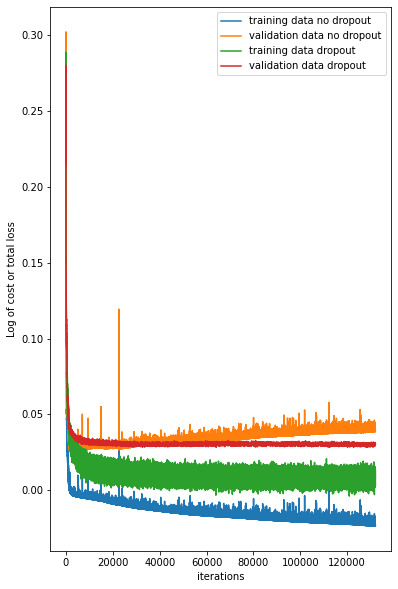

In [23]:
plt.figure(figsize=(6.1, 10))
for key, value in LOSS.items():
    plt.plot(np.log(np.array(value)), label=key)
    plt.legend()
    plt.xlabel("iterations")
    plt.ylabel("Log of cost or total loss")